Step 1: Import & cleaning data

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

(1) date: Date in format dd/mm/yyyy
(2) time: time in format hh:mm:ss
(3) global_active_power: household global minute-averaged active power (in kilowatt)
(4) global_reactive_power: household global minute-averaged reactive power (in kilowatt)
(5) voltage: minute-averaged voltage (in volt)
(6) global_intensity: household global minute-averaged current intensity (in ampere)
(7) sub_metering_1: energy sub-metering No. 1 (in watt-hour of active energy). It corresponds to the kitchen, containing mainly a dishwasher, an oven and a microwave (hot plates are not electric but gas powered).
(8) sub_metering_2: energy sub-metering No. 2 (in watt-hour of active energy). It corresponds to the laundry room, containing a washing-machine, a tumble-drier, a refrigerator and a light.
(9) sub_metering_3: energy sub-metering No. 3 (in watt-hour of active energy). It corresponds to an electric water-heater and an air-conditioner.

**Importing the txt file takes more time than that of csv file.**

In [2]:
df = pd.read_csv('/content/drive/MyDrive/archive.zip (Unzipped Files)/household_power_consumption.txt', sep=';', 
                 parse_dates={'dt' : ['Date', 'Time']}, infer_datetime_format=True, 
                 low_memory=False, na_values=['nan','?'], index_col='dt')

In [3]:
df.shape

(2075259, 7)

In [4]:
df.isnull().sum()


Global_active_power      25979
Global_reactive_power    25979
Voltage                  25979
Global_intensity         25979
Sub_metering_1           25979
Sub_metering_2           25979
Sub_metering_3           25979
dtype: int64

In [5]:
df = df.fillna(df.mean())
df.isnull().sum()

Global_active_power      0
Global_reactive_power    0
Voltage                  0
Global_intensity         0
Sub_metering_1           0
Sub_metering_2           0
Sub_metering_3           0
dtype: int64

In [6]:
df.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
dt,,,,,,,
2006-12-16 17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0
2006-12-16 17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0
2006-12-16 17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0
2006-12-16 17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0
2006-12-16 17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0


Step 2: Data visualizations

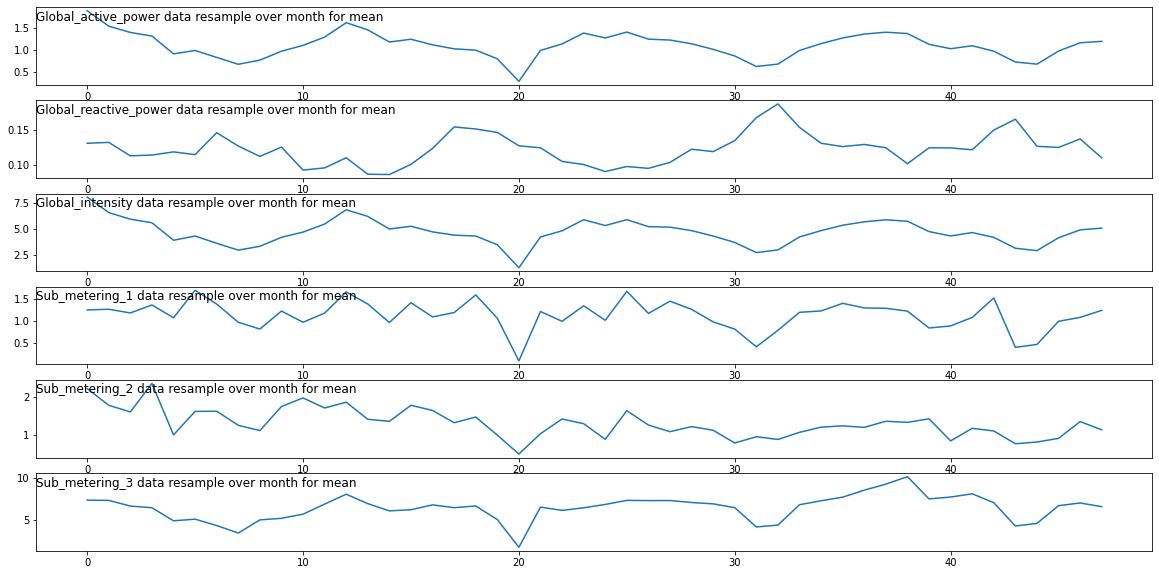

In [7]:
import matplotlib.pyplot as plt

i = 1
cols=[0, 1, 3, 4, 5, 6]
plt.figure(figsize=(20, 10))
for col in cols:
    plt.subplot(len(cols), 1, i)
    plt.plot(df.resample('M').mean().values[:, col])
    plt.title(df.columns[col] + ' data resample over month for mean', y=0.75, loc='left')
    i += 1
plt.show()

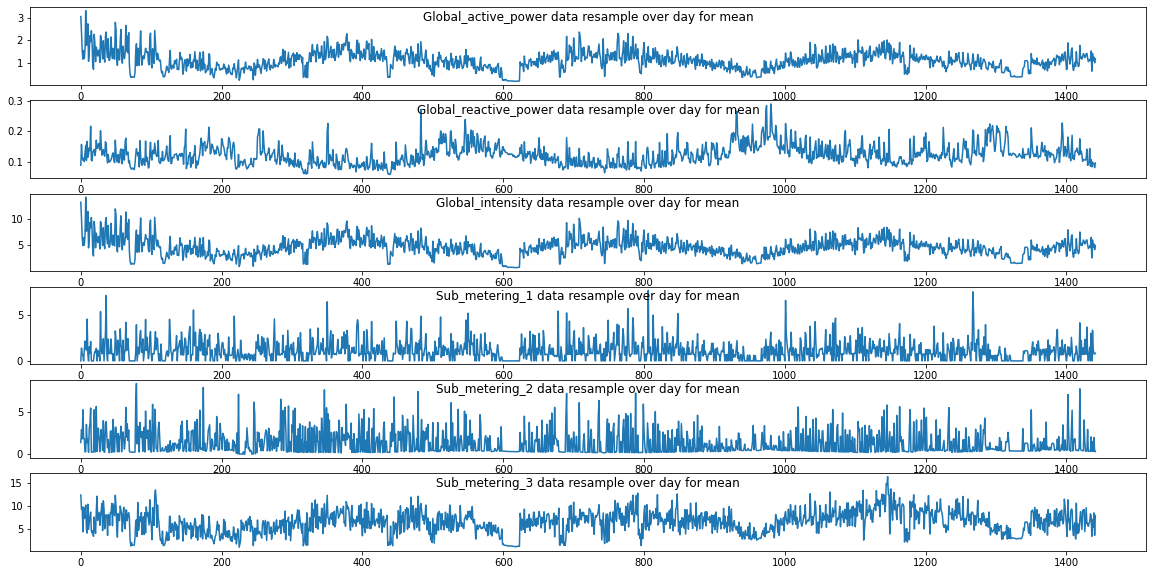

In [8]:
i = 1
cols=[0, 1, 3, 4, 5, 6]
plt.figure(figsize=(20, 10))
for col in cols:
    plt.subplot(len(cols), 1, i)
    plt.plot(df.resample('D').mean().values[:, col])
    plt.title(df.columns[col] + ' data resample over day for mean', y=0.75, loc='center')
    i += 1
plt.show()

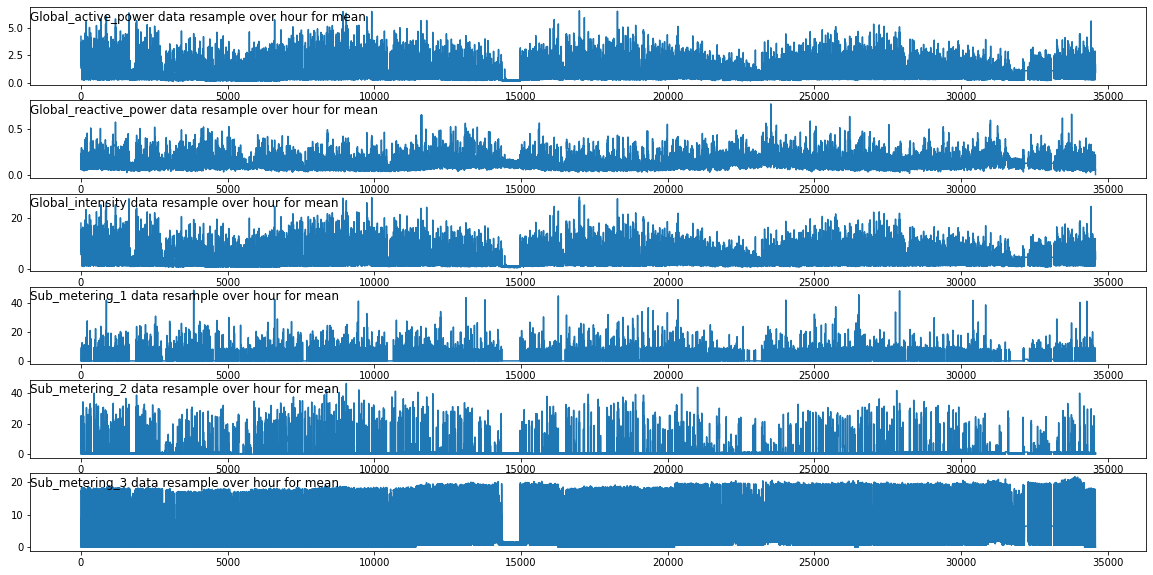

In [9]:
i = 1
cols=[0, 1, 3, 4, 5, 6]
plt.figure(figsize=(20, 10))
for col in cols:
    plt.subplot(len(cols), 1, i)
    plt.plot(df.resample('H').mean().values[:, col])
    plt.title(df.columns[col] + ' data resample over hour for mean', y=0.75, loc='left')
    i += 1
plt.show()

In [10]:
df.corr()


,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
Global_active_power,1.000000,0.247017,-0.399762,0.998889,0.484401,0.434569,0.638555
Global_reactive_power,0.247017,1.000000,-0.112246,0.266120,0.123111,0.139231,0.089617
Voltage,-0.399762,-0.112246,1.000000,-0.411363,-0.195976,-0.167405,-0.268172
Global_intensity,0.998889,0.266120,-0.411363,1.000000,0.489298,0.440347,0.626543
Sub_metering_1,0.484401,0.123111,-0.195976,0.489298,1.000000,0.054721,0.102571
Sub_metering_2,0.434569,0.139231,-0.167405,0.440347,0.054721,1.000000,0.080872
Sub_metering_3,0.638555,0.089617,-0.268172,0.626543,0.102571,0.080872,1.000000


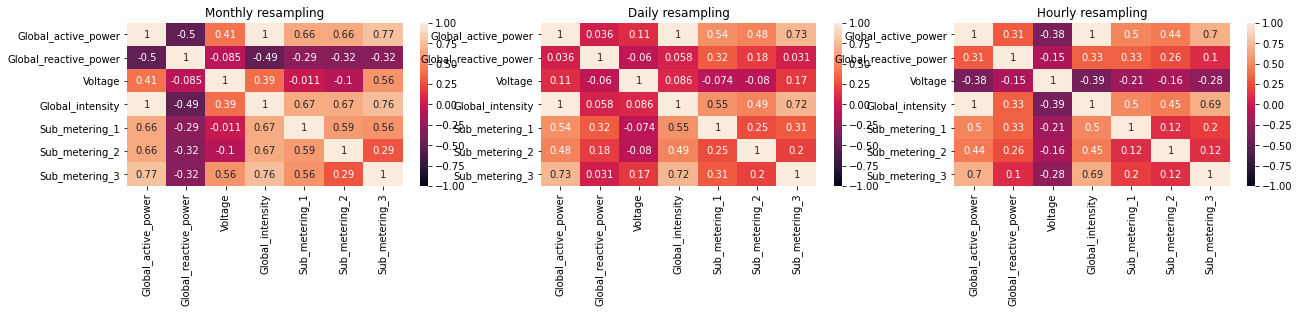

In [11]:
import seaborn as sns
f= plt.figure(figsize=(21,3))

ax=f.add_subplot(131)
dfm = df.resample('M').mean()
sns.heatmap(dfm.corr(), vmin=-1, vmax=1, annot=True)
plt.title('Monthly resampling', size=12)

ax=f.add_subplot(132)
dfd = df.resample('D').mean()
sns.heatmap(dfd.corr(), vmin=-1, vmax=1, annot=True)
plt.title('Daily resampling', size=12)
  
ax=f.add_subplot(133)
dfh = df.resample('H').mean()
sns.heatmap(dfh.corr(), vmin=-1, vmax=1, annot=True)
plt.title('Hourly resampling', size=12)
plt.show()

Step 3: LSTM Data Preparation and fitting


In [12]:
df = df[['Global_active_power', 'Global_reactive_power', 'Voltage',
       'Global_intensity', 'Sub_metering_2', 'Sub_metering_1','Sub_metering_3']]

In [13]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    dff = pd.DataFrame(data)
    cols, names = list(), list()
    for i in range(n_in, 0, -1):
        cols.append(dff.shift(-i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    for i in range(0, n_out):
        cols.append(dff.shift(-i))
        if i==0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1)) for j in range(n_vars)]        
        agg = pd.concat(cols, axis=1)
        agg.columns = names
        if dropnan:
            agg.dropna(inplace=True)
        return agg

In [14]:
df_resample = df.resample('h').mean() 
df_resample.shape

(34589, 7)

In [109]:
from sklearn.preprocessing import MinMaxScaler

values = df_resample.values
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
reframed = series_to_supervised(scaled, 1, 1)
r = list(range(df_resample.shape[1]+1, 2*df_resample.shape[1]))
reframed.drop(reframed.columns[r], axis=1, inplace=True)
reframed.head()

# Data spliting into train and test data series. Only 4000 first data points are selected for traing purpose.
values = reframed.values
n_train_time = 4000
train = values[:n_train_time, :]
test = values[n_train_time:, :]
train_x, train_y = train[:, :-1], train[:, -1]
test_x, test_y = test[:, :-1], test[:, -1]
train_x = train_x.reshape((train_x.shape[0], 1, train_x.shape[1]))
test_x = test_x.reshape((test_x.shape[0], 1, test_x.shape[1]))

LSTM model setting

Epoch 1/100
32/32 - 2s - loss: 0.0458 - val_loss: 0.0162
Epoch 2/100
32/32 - 0s - loss: 0.0244 - val_loss: 0.0139
Epoch 3/100
32/32 - 0s - loss: 0.0193 - val_loss: 0.0131
Epoch 4/100
32/32 - 0s - loss: 0.0175 - val_loss: 0.0119
Epoch 5/100
32/32 - 0s - loss: 0.0163 - val_loss: 0.0112
Epoch 6/100
32/32 - 0s - loss: 0.0154 - val_loss: 0.0107
Epoch 7/100
32/32 - 0s - loss: 0.0151 - val_loss: 0.0104
Epoch 8/100
32/32 - 0s - loss: 0.0146 - val_loss: 0.0103
Epoch 9/100
32/32 - 0s - loss: 0.0144 - val_loss: 0.0101
Epoch 10/100
32/32 - 0s - loss: 0.0141 - val_loss: 0.0100
Epoch 11/100
32/32 - 0s - loss: 0.0139 - val_loss: 0.0099
Epoch 12/100
32/32 - 0s - loss: 0.0137 - val_loss: 0.0097
Epoch 13/100
32/32 - 0s - loss: 0.0135 - val_loss: 0.0097
Epoch 14/100
32/32 - 0s - loss: 0.0132 - val_loss: 0.0096
Epoch 15/100
32/32 - 0s - loss: 0.0132 - val_loss: 0.0095
Epoch 16/100
32/32 - 0s - loss: 0.0131 - val_loss: 0.0094
Epoch 17/100
32/32 - 0s - loss: 0.0129 - val_loss: 0.0094
Epoch 18/100
32/32 - 0s

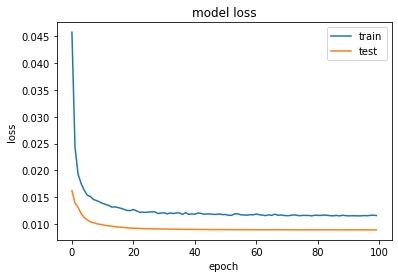

Test RMSE: 0.607


In [110]:
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import Dense
from sklearn.metrics import mean_squared_error,r2_score
import matplotlib.pyplot as plt
import numpy as np
 
model = Sequential()
model.add(LSTM(20, input_shape=(train_x.shape[1], train_x.shape[2])))
model.add(Dropout(0.1))
model.add(Dense(1, activation='relu'))
model.compile(loss='mean_squared_error', optimizer='adam')
 
# Network fitting
history = model.fit(train_x, train_y, epochs=100, batch_size=125, validation_data=(test_x, test_y), verbose=2, shuffle=False )
 
# Loss history plot
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()
 
size = df_resample.shape[1]
 
# Prediction test
yhat = model.predict(test_x)
test_x = test_x.reshape((test_x.shape[0], size))
 
# invert scaling for prediction
inv_yhat = np.concatenate((yhat, test_x[:, 1-size:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
 
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_y, test_x[:, 1-size:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
 
# calculate RMSE
rmse = np.sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

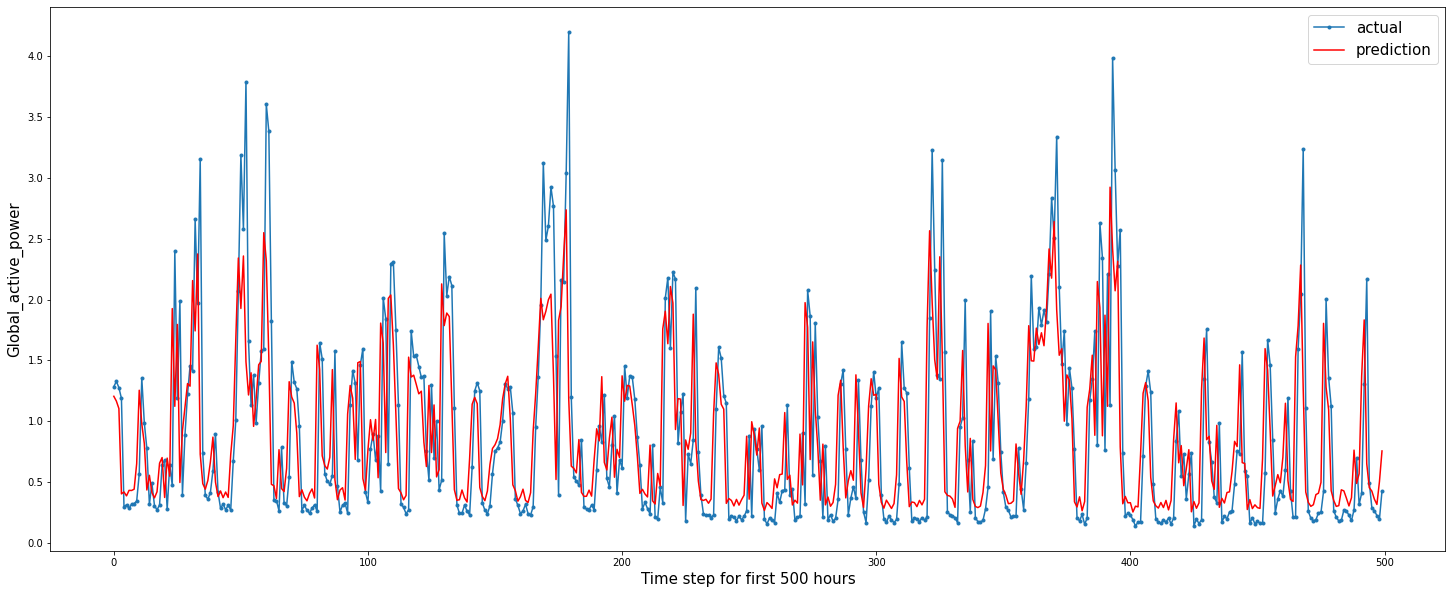

In [123]:
aa=[x for x in range(500)]
plt.figure(figsize=(25,10)) 
plt.plot(aa, inv_y[:500], marker='.', label="actual")
plt.plot(aa, inv_yhat[:500], 'r', label="prediction")
plt.ylabel(df.columns[0], size=15)
plt.xlabel('Time step for first 500 hours', size=15)
plt.legend(fontsize=15)
plt.show()

In [111]:
inv_yhat[1]


1.166528785399596

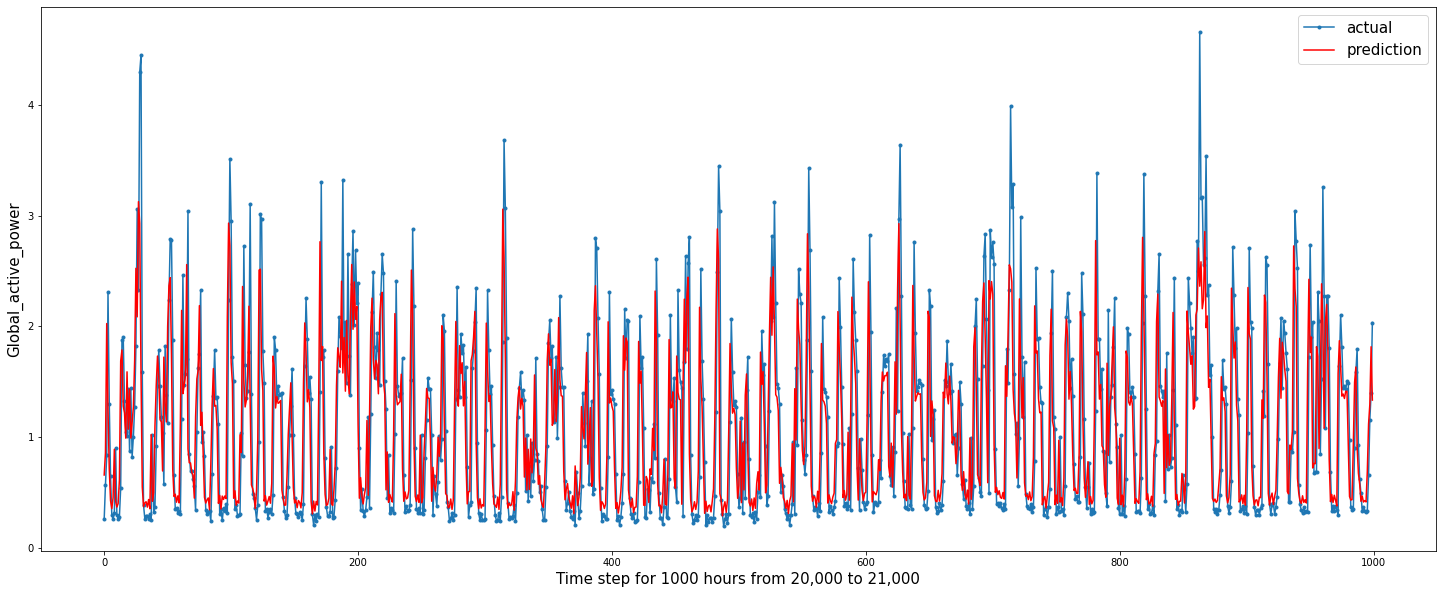

In [112]:
aa=[x for x in range(1000)]
plt.figure(figsize=(25,10)) 
plt.plot(aa, inv_y[20000:21000], marker='.', label="actual")
plt.plot(aa, inv_yhat[20000:21000], 'r', label="prediction")
plt.ylabel(df.columns[0], size=15)
plt.xlabel('Time step for 1000 hours from 20,000 to 21,000', size=15)
plt.legend(fontsize=15)
plt.show()

In [113]:
df = df[['Sub_metering_3','Global_active_power', 'Global_reactive_power', 'Voltage',
       'Global_intensity', 'Sub_metering_2', 'Sub_metering_1']]

In [114]:
df_resample = df.resample('h').mean() 
df_resample.shape

(34589, 7)

In [115]:
from sklearn.preprocessing import MinMaxScaler

values = df_resample.values
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
reframed = series_to_supervised(scaled, 1, 1)
r = list(range(df_resample.shape[1]+1, 2*df_resample.shape[1]))
reframed.drop(reframed.columns[r], axis=1, inplace=True)
reframed.head()

# Data spliting into train and test data series. Only 4000 first data points are selected for traing purpose.
values = reframed.values
n_train_time = 4000
train = values[:n_train_time, :]
test = values[n_train_time:, :]
train_x, train_y = train[:, :-1], train[:, -1]
test_x, test_y = test[:, :-1], test[:, -1]
train_x = train_x.reshape((train_x.shape[0], 1, train_x.shape[1]))
test_x = test_x.reshape((test_x.shape[0], 1, test_x.shape[1]))

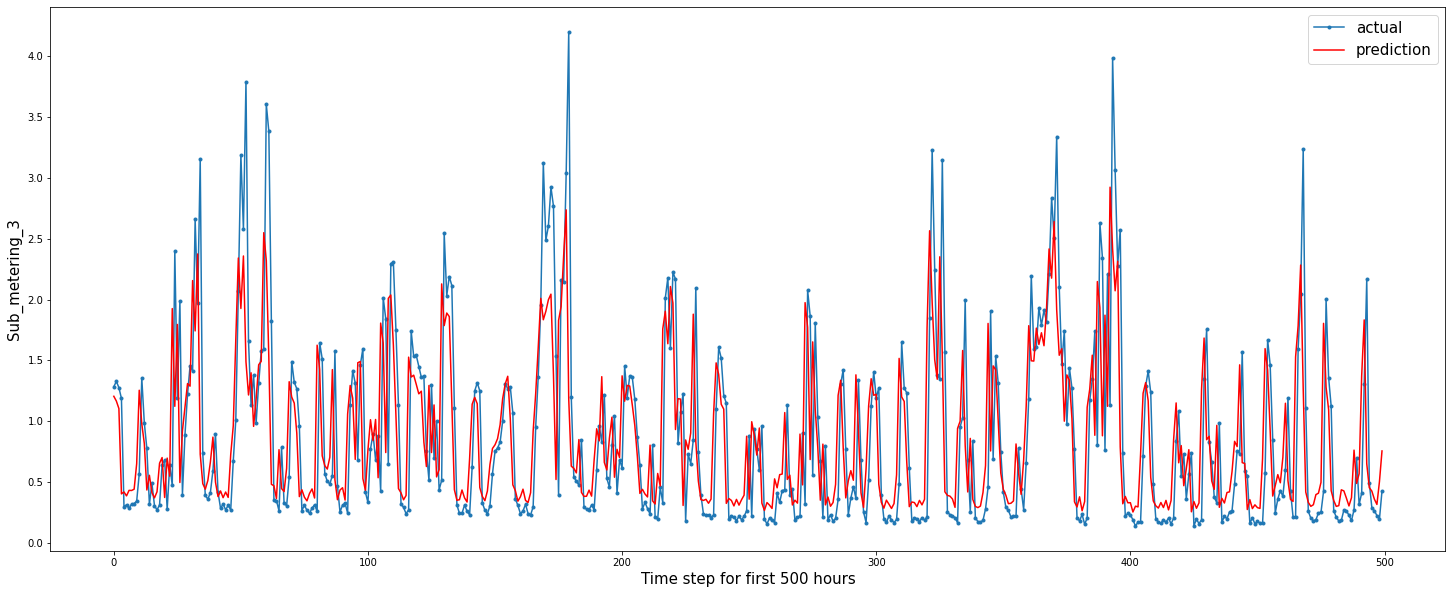

In [116]:
aa=[x for x in range(500)]
plt.figure(figsize=(25,10)) 
plt.plot(aa, inv_y[:500], marker='.', label="actual")
plt.plot(aa, inv_yhat[:500], 'r', label="prediction")
plt.ylabel(df.columns[0], size=15)
plt.xlabel('Time step for first 500 hours', size=15)
plt.legend(fontsize=15)
plt.show()

In [117]:
df = df[['Global_active_power', 'Global_reactive_power', 'Voltage',
       'Global_intensity', 'Sub_metering_2', 'Sub_metering_1','Sub_metering_3']]
df = df.drop(['Voltage'],axis=1)

In [118]:
df.shape


(2075259, 6)

In [119]:
df_resample = df.resample('h').mean() 
df_resample.shape

(34589, 6)

In [120]:
from sklearn.preprocessing import MinMaxScaler

values = df_resample.values
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
reframed = series_to_supervised(scaled, 1, 1)
r = list(range(df_resample.shape[1]+1, 2*df_resample.shape[1]))
reframed.drop(reframed.columns[r], axis=1, inplace=True)
reframed.head()

# Data spliting into train and test data series. Only 4000 first data points are selected for traing purpose.
values = reframed.values
n_train_time = 4000
train = values[:n_train_time, :]
test = values[n_train_time:, :]
train_x, train_y = train[:, :-1], train[:, -1]
test_x, test_y = test[:, :-1], test[:, -1]
train_x = train_x.reshape((train_x.shape[0], 1, train_x.shape[1]))
test_x = test_x.reshape((test_x.shape[0], 1, test_x.shape[1]))

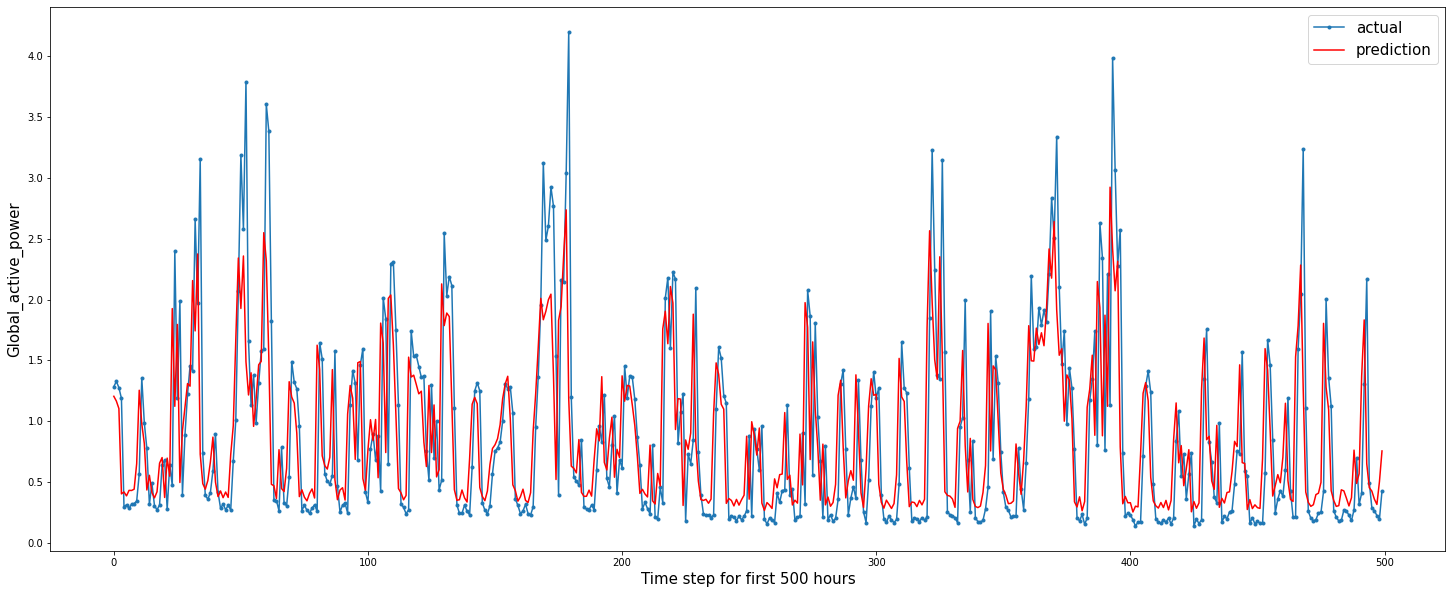

In [121]:
aa=[x for x in range(500)]
plt.figure(figsize=(25,10)) 
plt.plot(aa, inv_y[:500], marker='.', label="actual")
plt.plot(aa, inv_yhat[:500], 'r', label="prediction")
plt.ylabel(df.columns[0], size=15)
plt.xlabel('Time step for first 500 hours', size=15)
plt.legend(fontsize=15)
plt.show()

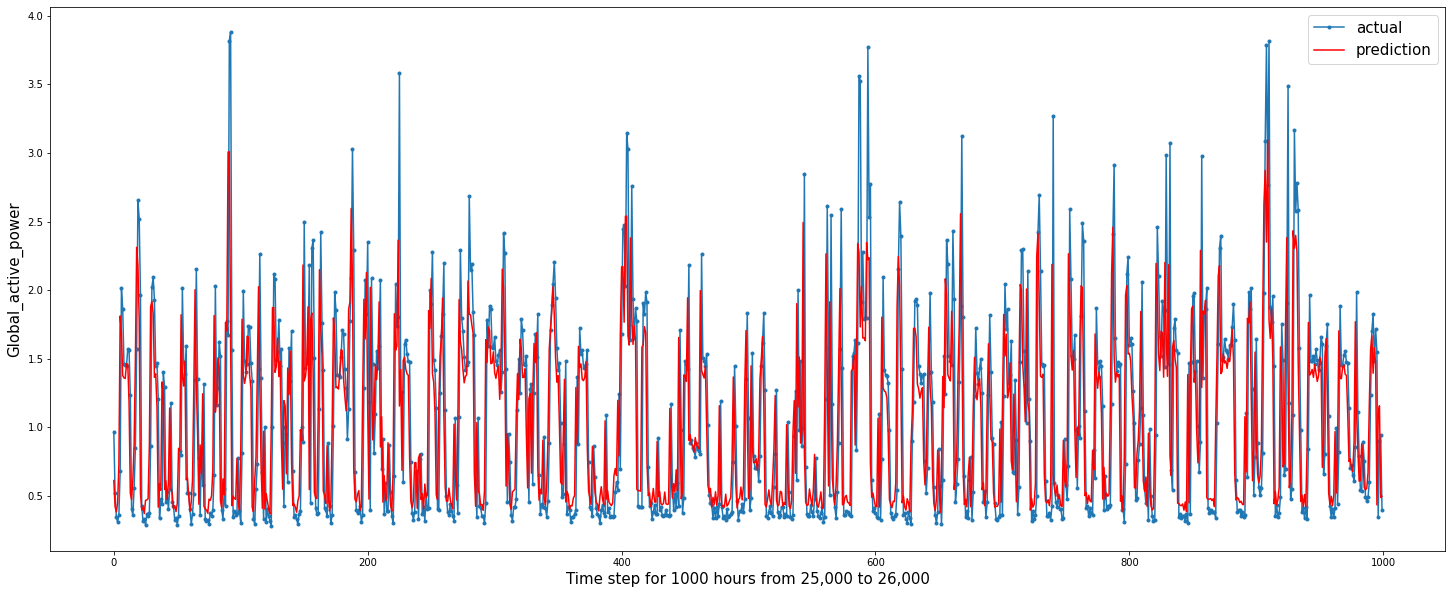

In [122]:
aa=[x for x in range(1000)]
plt.figure(figsize=(25,10)) 
plt.plot(aa, inv_y[25000:26000], marker='.', label="actual")
plt.plot(aa, inv_yhat[25000:26000], 'r', label="prediction")
plt.ylabel(df.columns[0], size=15)
plt.xlabel('Time step for 1000 hours from 25,000 to 26,000', size=15)
plt.legend(fontsize=15)
plt.show()